# How to Run a Directed Influence Campaign

For a directed influence campaign, we need text data where it is easy to tell who is speaking to who.  This type of data is hard to come by.  Free, open source social network datasets are either all text, or all nodes and edges, and we need both.  The combination of text + source + target information is powerful, and it is no surprise that it is well guarded.  But there is 1 source where it is much easier to come by: movie and TV dialogue.  We will use the dialogue for the HBO TV series Game of Thrones (GoT).  The dataset will consist of all 8 seasons of script text.  We will need to separate spoken text from text that describes what is going on in the scenes, and we will need to identify who is speaking.  These are only a couple of the many data cleaning steps we will need to perform before we can begin the more interesting, analytical work.  So let's get started!

In [1]:
import itertools
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import warnings

from functools import reduce
from collections import Counter
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
from dask import delayed
from scipy.sparse import coo_matrix, csgraph


warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Read the Data

The file, final_data.txt, is the complete script text from all 8 seasons.  The script text data was downloaded from: https://github.com/shekharkoirala/Game_of_Thrones.  

In [348]:
# read the raw dialogue data from all scenes in the TV show
with open ("../data/final_data.txt", "r") as f:
    data = f.readlines()

print(f"Total utterances in the entire show: {len(data):,}")

Total utterances in the entire show: 33,201


# Data Parsing

Now we will need to parse the data.  I have removed cells from this notebook where I did basic exploratory analysis to determine what work would need to be done.

## Entity Resolution

The script data contains many character name misspellings, nicknames, and incidences where last names are used.  If we do not correct and standardize these, they will be treated as separate entities.  There is no easy way to do this, so we will need to manually hardcode the character names.  This is where knowledge of the TV show comes in handy.  If you have not seen the show or read the books, IMDB would be the best place to determine who the main characters are.

## Scene Parsing

Scenes are separated by various means.  We will need to identify them by inspecting the data manually and looking to see how lines of dialogue and scenes are separated.  

## Creating Nodes and Edges

Once we have a complete list of resolved entities, we can turn them into nodes that will later form a graph.  We will form edges, or links, between them, based on who shared a scene together.

In [349]:
def resolve_identity(name: str):
    """
    Resolves entities with hardcoded character names that were manually taken from IMDB.  
    Since these are manual fixes, they are limited to main characters only.
    """
    # clean names
    name = re.sub("[\(\[].*?[\)\]]", "", name).strip().lower()

    # known substitutions, misspellings, and nicknames for main characters only
    if "ned" in name:
        name = "eddard"
    elif name == "jon":
        name = "jon snow"
    elif name == "ayra":
        name = "arya"
    elif name == "bron":
        name = "bronn"
    elif name == "catelyin":
        name = "catelyn"
    elif name == "-robb":
        name = "robb"
    elif name == "varys":
        name = "lord varys"
    elif name == "royce": 
        name = "waymar royce"
    elif name == "eurion":
        name = "euron"
    elif name == "grey worm":
        name = "greyworm"
    elif name == "melisdandre":
        name = "melisandre"
    elif name == "oleanna":
        name = "olenna"
    elif name == "ramsey":
        name = "ramsay"
    elif name == "snsa":
        name = "sansa"
    elif name == "gold cloack":
        name = "gold cloak"
    elif bool(
        [i for i in [
            "daenerys",  "daenarys", "daerneys", "daeynerys", "danaerys", "danerys", "denerys"
        ] if(i in name)]
    ):
        name = "daenerys"
    elif bool([i for i in ["jora", "jorah"] if(i in name)]):
        name = "jorah mormont"
    elif bool([i for i in ["samwell", "samwel", "sam"] if(i in name)]):
        name = "samwell tarly"
    elif bool([i for i in ["dooloroud edd", "dolrous edd", "doloroud edd"] if(i in name)]):
        name = "dolorous edd"
    elif bool([i for i in ["davos", "dav os"] if(i in name)]):
        name = "davos seaworth"
    elif bool([i for i in ["twyin", "tywen"] if(i in name)]):
        name = "tywin"
    elif bool([i for i in ["tyriom", "tyron"] if(i in name)]):
        name = "tyrion"
    elif bool([i for i in ["brienne", "brinee", "brinenne"] if(i in name)]):
        name = "brienne of tarth"
    elif bool([i for i in ["eddision", "edison", "eddison"] if(i in name)]):
        name = "eddison tollett"
    elif bool([i for i in ["cersie", "cesei"] if(i in name)]):
        name = "cersei"
    elif bool([i for i in ["king joffrey", "jofffrey"] if(i in name)]):
        name = "joffrey"
    elif bool([i for i in ["daaerio", "daario", "dario", "darrio"] if(i in name)]):
        name = "daario naharis"
    elif bool(
        [i for i in ["grand maester pyrcelle", "maester pycell", "maester pycelle", "pyelle", "pycelle", "pycell"] 
         if(i in name)]
    ):
        name = "grand maester pycelle"
    elif bool([i for i in ["alliser", "alliser thorn", "alliser throne"] if(i in name)]):
        name = "alliser thorne"
    elif bool([i for i in ["littlefinger", "petyr", "baelish"] if(i in name)]):
        name = "petyr 'littlefinger' baelish"
    elif bool([i for i in ["clegane", "hound", "sandor"] if(i in name)]):
        name = "sandor 'the hound' clegane"
    elif bool([i for i in ["gregor", "mountain"] if(i in name)]):
        name = "gregor 'the mountain' clegane"
    elif bool([i for i in ["khal", "drago"] if(i in name)]):
        name = "khal drago"
    
    # last names for main characters only
    if name in ["eddard", "catelyn", "sansa", "arya", "robb", "bran", "rickon", "telisa", "benjen", "lyanna"]:
        name += " stark"
    elif name in ["tyrion", "cersei", "jaime", "tywin", "lancel", "kevan", "alton"]:
        name += " lannister"
    elif name in ["theon", "yara", "euron", "balon"]:
        name += " greyjoy"
    elif name in ["daenerys", "viserys", "rhaegar"]:
        name += " targaryen"
    elif name in ["joffrey", "stannis", "tommen", "selyse", "shireen", "renly", "robert", "myrcella"]:
        name += " baratheon"
    elif name in ["margaery", "loras", "olenna", "mace"]:
        name += " tyrell"
    elif name in ["ramsay", "roose"]:
        name += " bolton"
    elif name in ["oberyn"]:
        name += " martell"
    
    # spelling
    if "targarian" in name:
        name = name.replace("targarian", "targaryen")
    
    return name


# run a few tests on this function
print(resolve_identity("Royce (person)"))
print(resolve_identity("jon"))
print(resolve_identity("ned"))

waymar royce
jon snow
eddard stark


In [350]:
def split_dialogue_into_scenes(data):
    """
    Parse dialogue text into scenes.  The raw text has several ways to indicate scene shifts, 
    such as [lines like this], lines like this:  -------, and lines like 'CUT TO:' or 'INT:'.  
    
    This function attempts to split the dialogue by scene.  However, a scene is defined here 
    as a separation between parts of dialogue.  There is no way to cleanly delineate actual 
    scenes, so by re-defining scene as a sement of dialogue separated by action, we can 
    somewhat separate dialogue between characters who are directly talking with one another. 
    """
    scenes = []
    scene = []
    for text in data:

        # lines of dialogue begin with the speaker's name followed by a colon, 
        # so first split each line wherever there are capital letters followed by a colon
        new_text = [t.strip() for t in re.split(r'[:]', text)]

        # if the first string in the new_text list is all caps, it might be a speaker's name
        try:
            speaker_name_candidate = len(re.findall(r'[A-Z\s]+', new_text[0])[0]) == len(new_text[0]) 
        except IndexError:
            speaker_name_candidate = False
        if speaker_name_candidate and new_text[0] not in [
            'INT', 'EXT', 'CUT', 'CUT TO', 'CUT  TO', 'COLD OPEN', 'END COLD OPEN', 'CREDITS', 'MAIN CREDITS',
            'END CREDITS', 'END EPISODE', 'END SEASON', 'EXT WINTERFELL', 'TITLE SEQUENCE', 'BEYOND THE WALL',
            'NO SPOILERS IF YOU HAVE READ THE BOOKS', 'COURTYARD'
        ]:
            scene.append(text)

        # breaks between scenes can either start and end with brackets, have a bunch of dashes, 
        # or start with INT, EXT, or CUT TO
        if (
            ("[" in text[:5] and "]" in text[-5:]) 
            or ("------" in text) 
            or (speaker_name_candidate and new_text[0] in [
                'INT', 'EXT', 'CUT', 'CUT TO', 'CUT  TO', 'COLD OPEN', 'END COLD OPEN', 'CREDITS', 'MAIN CREDITS',
                'END CREDITS', 'END EPISODE', 'END SEASON', 'EXT WINTERFELL', 'TITLE SEQUENCE', 'BEYOND THE WALL',
                'NO SPOILERS IF YOU HAVE READ THE BOOKS', 'COURTYARD'
            ])
        ):
            if len(scene) > 0:
                scenes.append(scene)
            scene = []

    return scenes

In [351]:
scenes = split_dialogue_into_scenes(data)
print(f"Total Scenes: {len(scenes)}")

Total Scenes: 1018


In [352]:
def get_nodes_and_edges_for_dialogue(scenes):
    """
    Create a set of characters (nodes) and their links/edges.  Characters speaking together in the same scene 
    will be assumed to be interacting, so an edge will be formed between them.  Edges will be undirected.  
    The edge list will contain tuples that can be used to build a graph.  Number of shared scenes could be used 
    as the edge weight.  Alternatively, number of interactions could be used as the edge weight.
    """
    nodes = set()
    edges = list()      # edges to be used if number of shared scenes is the edge weight
    edges_int = list()  # edges to be used if number of interactions is the edge weight
    for scene in scenes:
        nodes_in_scene = set()
        for line in scene:
            node_name = resolve_identity(line.split(":")[0])
            nodes.add(node_name)
            nodes_in_scene.add(node_name)
        # assume everybody in the scene is interacting, so form links between all of them
        edges += list(itertools.combinations(nodes_in_scene, 2))  # 1 edge per scene
        edges_int += (list(itertools.combinations(nodes_in_scene, 2)) * len(scene)) # 1 edge per interaction
    return nodes, edges, edges_int

In [353]:
nodes_by_name, edges, edges_int = get_nodes_and_edges_for_dialogue(scenes)
print(f"Total nodes: {len(nodes_by_name)}, and edges: {len(edges):,}")

Total nodes: 437, and edges: 17,476


## Edge Weighting

We will create an undirected graph, because it would be difficult to determine who is speaking to who from the text alone.  We have assumed that if 2 characters are in a scene together, they are interacting.  The total scenes shared by 2 characters is therefore their edge weight.  Recall that we are using the word 'scene' liberally.  Our scene parser is doing a decent job, but there are many scenes with action spliced into the scene, and our parser considers the text on either side of the action a separate scene.  So we almost certainly have more scenes than there actually are in the show, and therefore more interactions counting towards the edge weights than there should be. 

There is a drawback to using shared scenes to determine edge weight though: scene length should matter.  If 2 characters have very few scenes together, but interact substantially in the few scenes they have, their relationship should be considered stronger.  Similarly, if 2 characters have many scenes together, but hardly interact, their relationship should be weaker.  Consider for instance, a character like 'soldier', a generic character appearing in many scenes who usually speaks very little.  This character's relationships to main characters should not be inflated by shared scenes or by scene length.  So we need an edge weight that takes both factors into consideration.  A first pass could be the average, or just number of interactions / number of shared scenes.  However, we want higher shared scenes AND higher total interactions to increase weight, and if we use an average like this, a higher number of shared scenes would drag the weight down, rather than push it up.  Instead, we will multiply the numbers together.  A distribution plot of edge weight should indicate whether this is a good idea.

In [354]:
# create an ID for each node
nodes = {i: v for i, v in enumerate(nodes_by_name)}
node_to_id_map = {v: k for k, v in nodes.items()}

In [355]:
# de-duplicate edges
edges_sorted = [tuple(sorted(tup, key = lambda x: x[0])) for tup in edges]
edges_weighted_by_scene = dict(Counter(i for i in edges_sorted))

edges_int_sorted = [tuple(sorted(tup, key = lambda x: x[0])) for tup in edges_int]
edges_weighted_by_interaction = dict(Counter(i for i in edges_int_sorted))

In [356]:
# weight edges by number of interactions * number of shared scenes
edges_weighted = reduce(
    lambda x, y: dict((k, v * y[k]) for k, v in x.items()), 
    [edges_weighted_by_scene, edges_weighted_by_interaction]
)

In [357]:
print(len(edges_weighted))

8755


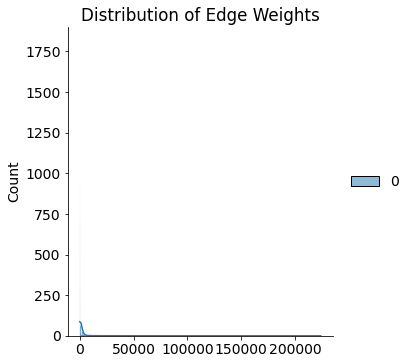

In [358]:
sns.displot(edges_weighted.values(), kde=True)
plt.title("Distribution of Edge Weights")
plt.show()

The distribution of edge weights is highly skewed and the variance is high.  We can reduce the variance by transforming the data and reducing the skew.  We could take the log here, but to preserve the relative distance between weights, we will take the cube root instead.

In [359]:
# transform edge weights
new_weights = list(np.cbrt(list(edges_weighted.values())))
dict_index = 0
for k,v in edges_weighted.items():
    edges_weighted[k] = new_weights[dict_index]
    dict_index += 1

In [360]:
print("Max edge weight:", np.max(list(edges_weighted.values())))

Max edge weight: 60.74009276928635


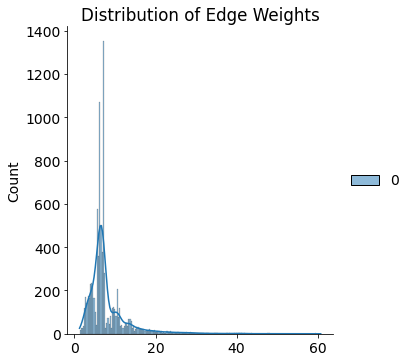

In [361]:
sns.displot(edges_weighted.values(), kde=True)
plt.title("Distribution of Edge Weights")
plt.show()

# Construct Network Graph

Now that we have the edge list, we can convert that to a graph.  The graph will be central to our future network analysis.

In [362]:
# convert edges dict to have edges by node ID
edges_weighted_by_id = {(node_to_id_map[k[0]], node_to_id_map[k[1]]): v for k, v in edges_weighted.items()}

In [363]:
# save edges to a Pandas dataframe
output_df = pd.concat([
    pd.DataFrame(list(edges_weighted)),
    pd.DataFrame(list(edges_weighted_by_id)),
    pd.DataFrame(list(edges_weighted.values()))
], axis=1, ignore_index=True)
output_df.columns = ["source_name", "target_name", "source_id", "target_id", "weight"]
# output_df.to_csv("../data/edges.csv", index=False)
output_df.head()

source_name   target_name  source_id  target_id    weight
0          gared  waymar royce         17        145  3.391211
1          gared          will         17        290  2.802039
2   waymar royce          will        145        290  3.391211
3  septa mordane   sansa stark        147        155  1.259921
4       jon snow    robb stark        288        397  5.289572

In [364]:
G = nx.parse_edgelist(
    [" ".join([str(k[0]), str(k[1]), str(v)]) for k, v in edges_weighted_by_id.items()],
    data=(("weight", float),)
)

# determine node position from the spring layout (could use any layout, but I prefer spring)
pos = nx.spring_layout(G)

# assign node data attributes position, node ID, and name
for n in G.nodes:
    G.nodes[n]['pos'] = pos[n]
    G.nodes[n]['id'] = n
    G.nodes[n]['name'] = nodes[int(n)]

## Centrality (Influence)

Influence is key to our campaign.  We need to know who has the most influence in the network, so that we can most effectively spread our message.  Next we will calculate 2 centrality measures that will serve as ways to measure influence:
1. Betweenness Centrality - nodes that connect disparate parts of the graph are more influential.  People with high betweenness centrality are the people who connect multiple social groups.
2. Eigenvector Centrality - nodes that are connected to other well connected nodes are more influential.  People with high eigenvector centrality are the people who likely have high social statuses in the network.

We will scale the influence scores to the range (0,1) so that they are on comparable scales.  This will come in handy later when we try to determine the best people to spread our message.

### Drawbacks to centrality as a proxy measure of influence

Centrality measures reach through the network, and not necessarily influence.  A famous person might have a higher centrality in a social network than your best friend, but if you hear about some new product from that famous person, and you hear about a competitive product from your best friend, which connection are you more likely to listen to?  If the goal is to send a message across the greatest span of the network, then centrality is a good measure to optimize.  However, relationship strength and conviction matter when it comes to spreading influence.  We are using centrality because it is easy to measure.  We have edge weights to measure relationship strength, but edges operate more locally.  If we want to know the best person to send our message to who will influence person A, then we just need to find the highest edge weight for person A.  But if we want to know the best person to send our message to who will potentially influence the greatest number of people, centrality can help us.

### Influence decay and the network horizon

Christakis and Fowler, 2007, found that social networks exhibit influence decay.  Influence drops exponentially such that by the 4th degree, influence is practically negligible.  So only the first 3 degrees are impacted by influence.  The degree to which influence extends is known as the network horizon or 3 degrees of influence.

The network horizon and influence decay are not factors that apply to the transmission of information between nodes, but rather an attribute that naturally results from the normal transmission of information.  Many social networks exhibit preferential attachment, causing a Pareto style distribution of links.  Yet despite variations in the distribution of centrality, all nodes have similar patterns of influence decay.  Therefore, by collecting the list of nodes within 3 degrees of any given node, we can be confident that the influence of this node will extend no further.  Highly connected nodes may have a larger radii that less connected nodes, and thus nodes with higher centrality measures may have larger radii or influence reach.  The next cell below shows an example of the influence decay curve, simply for illustration.  

If we want to know how much influence person A exerts on person B, we can multiply their edge weight by person A's influence measure (centrality in this case).  But social networks are no like neural networks: there is no gradient to backpropagate and determine how much influence can be attributed to which node.  There is simply no way to determine precisely how much influence spreads from person A to every other node in the network, or how much of person A's influence travels through B and gets to C.  In the absence of such information, we can rely on the network horizon to approximate influence spread.  Think of edge weights as a microscopic view of influence, and network horizon as a macroscopic view of influence.  The network horizon is a heuristic that can help us estimate influence spread throughout the network.

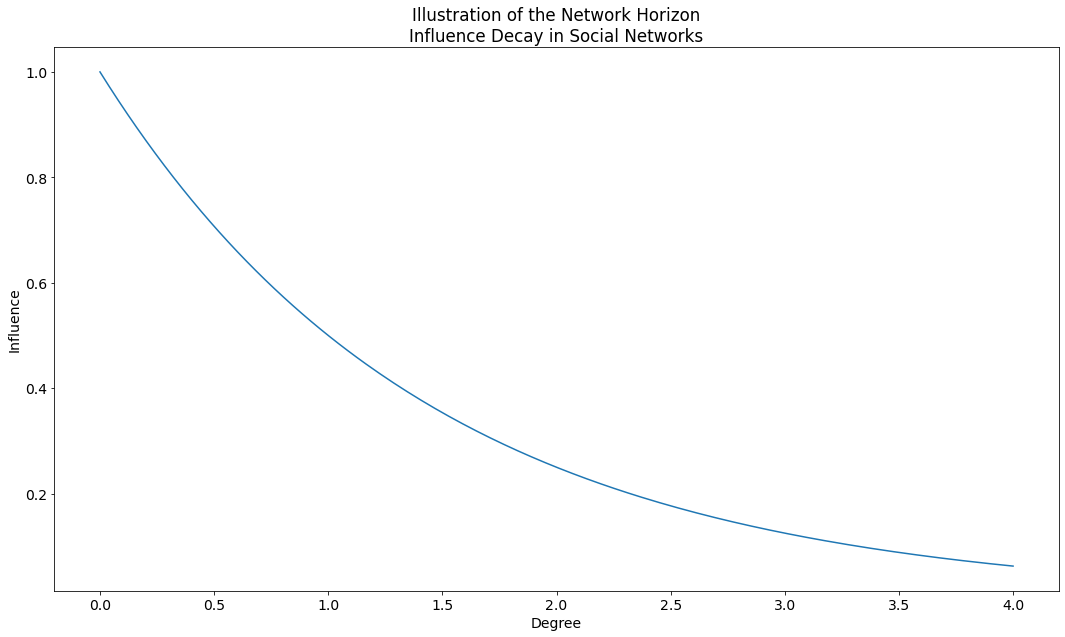

In [365]:
# create an exponential decay curve that mimics the 3 degrees of influence
# if influence to 1st degree is 0.5, then it halves every degree
influence_decay_curve = [0.5**x for x in np.linspace(0, 4, 200)]
plt.title("Illustration of the Network Horizon\nInfluence Decay in Social Networks")
plt.xlabel("Degree")
plt.ylabel("Influence")
plt.plot([x for x in np.linspace(0, 4, 200)], influence_decay_curve)

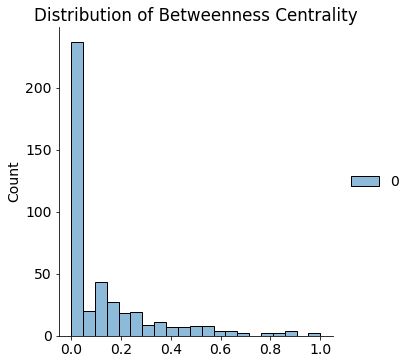

In [366]:
# calculate centrality
centrality_betw = nx.betweenness_centrality(G, normalized=True, endpoints=False)
centrality_betw = {
    int(k): v
    for k, v in sorted(centrality_betw.items(), key=lambda item: item[1], reverse=True)
}

# cube root to shift distribution of centrality towards normal, then normalize centrality scores
centrality_betw_scaler = MinMaxScaler()
centrality_betw_scaler.fit(
    np.cbrt(list(centrality_betw.values())).reshape(-1, 1)
)
centrality_betw = {
    k: centrality_betw_scaler.transform(
        np.cbrt(v).reshape(1, 1)
    )[0][0] for k, v in centrality_betw.items()
}

sns.displot(centrality_betw.values())
plt.title("Distribution of Betweenness Centrality")
plt.show()

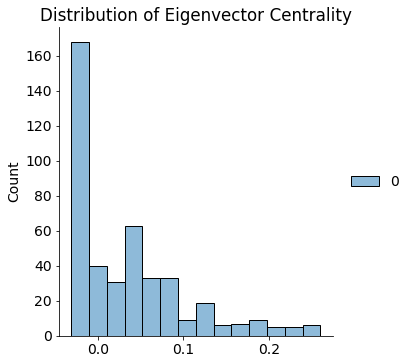

In [367]:
# calculate centrality
centrality_eig = nx.eigenvector_centrality(G)
centrality_eig = {
    int(k): v 
    for k, v in sorted(centrality_eig.items(), key=lambda item: item[1], reverse=True)
}

# cube root here shifts the distribution close to normal, but too close,
# I want the distribution to be similar to betweenness centrality, 
# so eigenvector centrality will be normalized only
centrality_eig_scaler = MinMaxScaler()
centrality_eig_scaler.fit(
    np.cbrt(list(centrality_eig.values())).reshape(-1, 1)
)
centrality_eig = {
    k: centrality_eig_scaler.transform(
        np.array(v).reshape(1, 1)
    )[0][0] for k, v in centrality_eig.items()
}

sns.displot(centrality_eig.values())
plt.title("Distribution of Eigenvector Centrality")
plt.show()

In [368]:
# top 10 most influential
print("Top 10 most influential using betweenness centrality:")
for n in list(centrality_betw)[:10]:
    print(nodes[n], "-----", centrality_betw[n])
print("\nTop 10 most influential using eigenvector centrality:")
for n in list(centrality_eig)[:10]:
    print(nodes[n], "-----", centrality_eig[n])

Top 10 most influential using betweenness centrality:
daenerys targaryen ----- 1.0
man ----- 0.982413517741076
jon snow ----- 0.9044234480719485
jorah mormont ----- 0.8782975290677368
tyrion lannister ----- 0.8720177781556198
theon greyjoy ----- 0.8702342412299472
arya stark ----- 0.837135064462606
cersei lannister ----- 0.8189664190548819
sansa stark ----- 0.8042313716106302
davos seaworth ----- 0.7760729435825506

Top 10 most influential using eigenvector centrality:
tyrion lannister ----- 0.2596295202775741
arya stark ----- 0.24636758172398845
sansa stark ----- 0.2447047528011186
daenerys targaryen ----- 0.24230951059340153
jon snow ----- 0.24197489283176857
jaime lannister ----- 0.23944785346681016
cersei lannister ----- 0.23722880895189233
davos seaworth ----- 0.23649953553200706
man ----- 0.23228187717153956
samwell tarly ----- 0.2292842613918524


## Filter the Graph for Visualization

We could visualize the entire graph, but it would look like a tangled ball of yarn and we would not be able to make any sense of it.  It is common practice to visualize sub-graphs, as they are easier to digest.  So we will create a sub-graph that reduces the nodes based on number of links (the degree centrality).  This will ensure that only the nodes with the most links are in our graph.  We will also remove links whose weights are below some threshold.  This will ensure that the graph does not have so many links that it they are hard to see, and only the most important links will be visualized.

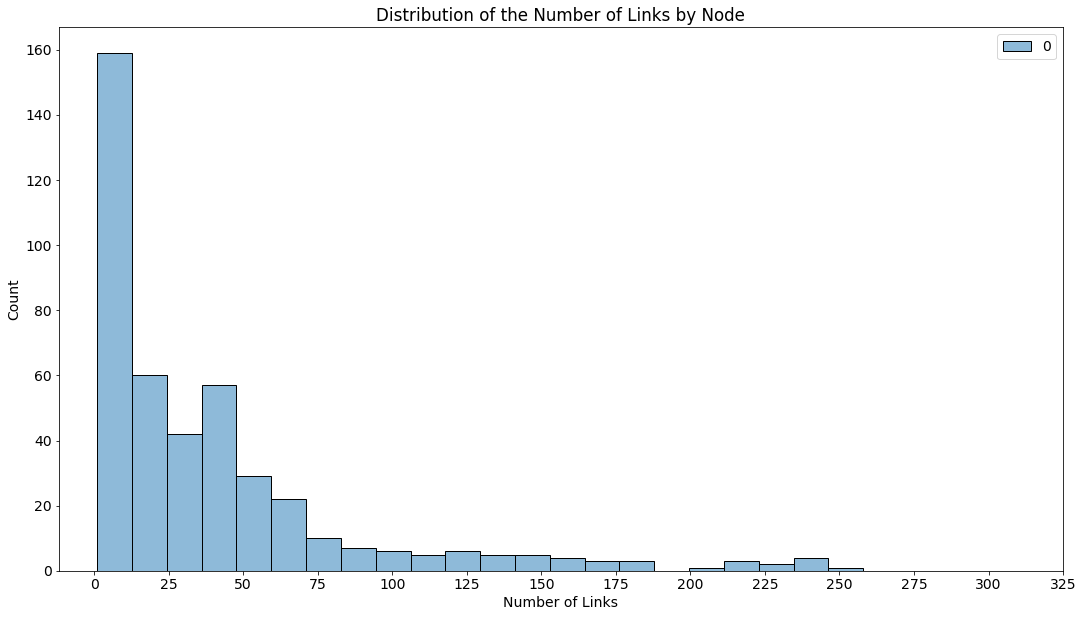

In [369]:
# view the distribution of degree centrality (nbr links) to determine where to cut it
nbr_links = dict(G.degree())
sns.histplot(nbr_links.values())
plt.xticks([i for i in range(0, 350, 25)])
plt.xlabel("Number of Links")
plt.title("Distribution of the Number of Links by Node")
plt.show()

It seems that thresholding the number of links around 125 would reduce the graph to a manageable size for visualization.

In [370]:
# remove nodes with < x links for easier plotting
min_x_links = 125
nodes_w_min_x_links = [n for n in G.nodes if len(list(G.neighbors(n))) >= min_x_links]
G_sub = G.subgraph(nodes_w_min_x_links)
print(f"Nodes before reduction: {len(G.nodes)} and after: {len(G_sub.nodes)}")

Nodes before reduction: 434 and after: 34


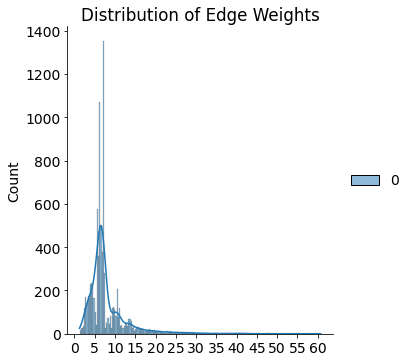

In [371]:
# review the distribution of edge weights to determine where to cut them
sns.displot(edges_weighted.values(), kde=True)
plt.title("Distribution of Edge Weights")
plt.xticks([i for i in range(0, 65, 5)])
plt.show()

It seems that thresholding the edge weights around 16 would reduce the graph to a manageable size for visualization.

In [372]:
# remove links with < x weight for easier plotting
min_edge_weight = 16
selected_edges = [
    str(u) + " " + str(v) + " " + str(e['weight']) 
    for u, v, e in G_sub.edges(data=True) if e['weight'] >= min_edge_weight
]
G_subsub = nx.parse_edgelist(selected_edges, data=(("weight", float),))
pos = nx.spring_layout(G_subsub, seed=14)
for n in G_subsub.nodes:
    G_subsub.nodes[n]['pos'] = pos[n]
    G_subsub.nodes[n]['id'] = n
    G_subsub.nodes[n]['name'] = G_sub.nodes[n]['name']
print(f"Links before reduction: {len(G.edges):,} and after {len(G_subsub.edges)}")

Links before reduction: 8,711 and after 397


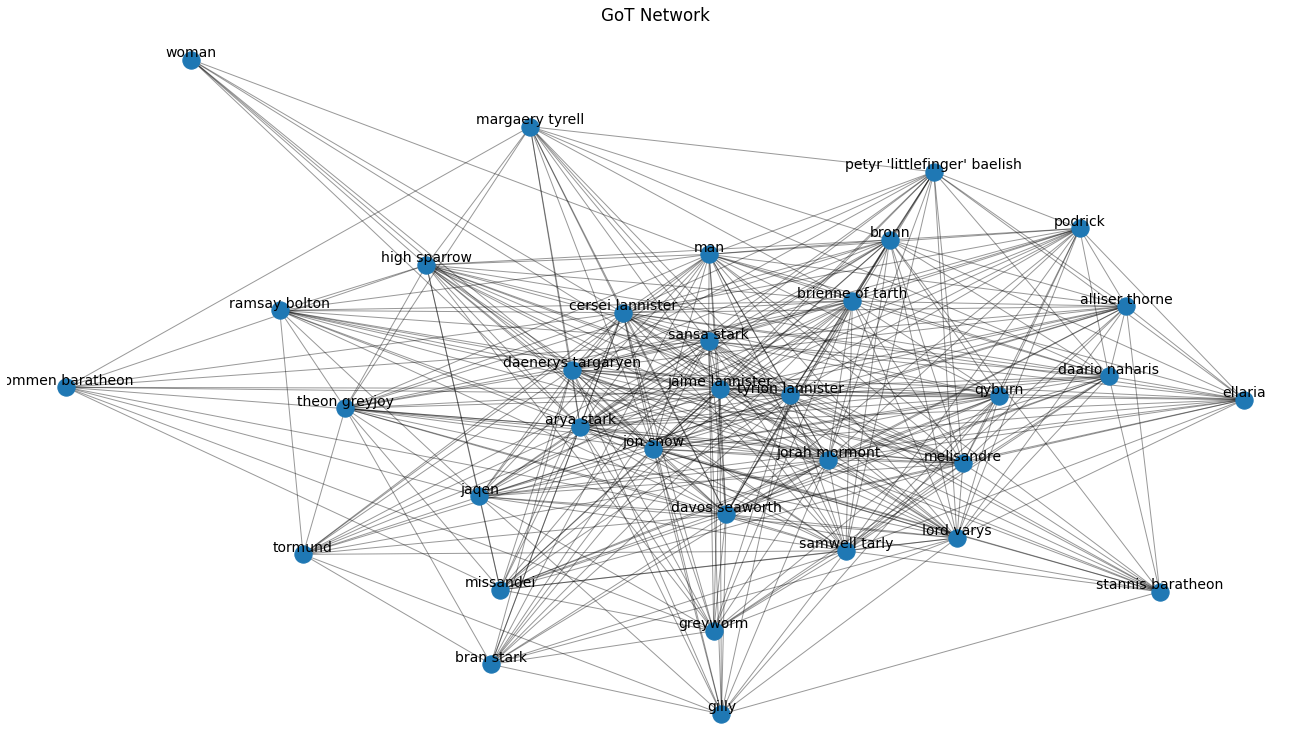

In [373]:
# plot params
plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams.update({'font.size': 14})

# draw network graph
labels = nx.get_node_attributes(G_subsub, 'name') 
nx.draw(
    G_subsub, 
    # node_color=color_map, 
    edge_color="#00000066", 
    pos=pos, 
    labels=labels,
    with_labels=True, 
    font_size=14, 
    verticalalignment="bottom"
)
plt.title("GoT Network")
# plt.savefig('1.png', bbox_inches='tight')
plt.show()

# Get the Dialogue by Character

We need to know who said what so that we can pair our message up with the people who would be best suited to receive it.

In [374]:
def get_node_texts_for_dialogue(scenes, nodes_by_name):
    """
    Create dict of every character (node) and a list of their dialogue texts.  This can be used for NLP.
    """
    node_texts = dict.fromkeys(nodes_by_name)
    # initialize each character's text history as empty list
    node_texts = {node: [] for node, node_text in node_texts.items()}
    for scene in scenes:
        for line in scene:
            node_name = resolve_identity(line.split(":")[0])
            if len(node_name) > 0:  # skip breaks between scenes
                node_texts[node_name] += [re.sub(r'\([^()]*\)', '', line.split(":")[1]).strip()]
    return node_texts

In [375]:
node_texts = get_node_texts_for_dialogue(scenes, nodes_by_name)
who_said_what = pd.concat(pd.DataFrame({'name': k, 'text': v}) for k, v in node_texts.items())
who_said_what['text'] = who_said_what['text'].astype(str).apply(lambda x: x.lower())
who_said_what.reset_index(drop=True, inplace=True)
who_said_what.reset_index(drop=False, inplace=True)
who_said_what.rename(columns={"index": "id"}, inplace=True)
who_said_what.head()

id       name                                               text
0   0  innkeeper                         please, she's a good girl.
1   1      rorge                 give us a beer. before i skin you.
2   2      rorge                 hey, you little shit. get us beer!
3   3      rorge  come closer. and i'll shove that stick up your...
4   4      rorge                                         come here!

In [376]:
assert(len(set(who_said_what['id'])) == len(who_said_what))

# Run the Campaign


## What message should we send?

Let's suppose we want to spread the news that King's Landing has a weak point at the mud gate.  This was a true but little known fact in the show and proved to be a strategic location for attacking the city.  Who should we tell so that the message will spread across the network?  Who will care the most?  How should we word the message to get attention from those who will care?


## Who should we send the message to?

To determine who to send the message to, we need to know who agrees with the goal or intent of our message.  Let's suppose that our goal is to help take King's Landing.  We would want to know who agrees with that goal.  So we will use a language model to predict how well each character's dialogue agrees with the statement "I want to attack King's Landing."  

In [377]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

If you have run the model before and saved who_said_what to a CSV file, load that file and avoid running the next 3 cells, because they take a while to run.

In [378]:
labels = [
    "i want to attack king's landing", 
    "attack battle warfare weapons strategy",
]

@delayed
def model_inference(texts: dict, labels: list):
    """Dask parallelized function to perform inference"""
    return {k: classifier(v, labels, multi_label=True) for k, v in texts.items()}

# limit the texts to run through the model to those >= 50 characters and that contain certain key words
key_words_to_search_for = ["king's landing"]
who_said_what_subset = who_said_what[
    who_said_what['text'].str.contains("|".join(word for word in key_words_to_search_for))
]
texts_for_inference = {
    i: t for i, t in dict(zip(who_said_what_subset['id'], who_said_what_subset['text'])).items() 
    if len(t) >= 50
}
print(len(texts_for_inference))

all_ans = model_inference(texts=texts_for_inference, labels=labels).compute()

122


In [379]:
# re-arrange data from {sequence: x, labels: [x,y], scores[x,y]} 
#  to {sequence: x, label_x: score_x, label_y: score_y}
all_ans_dict = dict()
for k, v in all_ans.items():
    new_ans = {'sequence': v['sequence']}
    for l in range(len(v['labels'])):
        new_ans[v['labels'][l]] = v['scores'][l]
    all_ans_dict[k] = new_ans

# for each label, create a mapping of index ID to the score value
new_column_maps = pd.DataFrame.from_dict(all_ans_dict, orient="index")
new_column_maps.reset_index(inplace=True)
new_column_maps.rename(columns={"index": "id"}, inplace=True)

# use the mappings to link dataframe index to score for the appropriate new column
# each label will be a new column
who_said_what = pd.merge(
    left=who_said_what, 
    right=new_column_maps.drop('sequence', axis=1), 
    how='left', 
    on='id'
)

In [380]:
who_said_what.to_csv("../data/who_said_what.csv", index=True)
who_said_what.head()

id       name                                               text  \
0   0  innkeeper                         please, she's a good girl.   
1   1      rorge                 give us a beer. before i skin you.   
2   2      rorge                 hey, you little shit. get us beer!   
3   3      rorge  come closer. and i'll shove that stick up your...   
4   4      rorge                                         come here!   

   attack battle warfare weapons strategy  i want to attack king's landing  
0                                     NaN                              NaN  
1                                     NaN                              NaN  
2                                     NaN                              NaN  
3                                     NaN                              NaN  
4                                     NaN                              NaN

In [381]:
# view characters who talk about attacking King's Landing
who_said_what[who_said_what[labels[0]] >= 0.5].head(10)

id               name  \
902      902  stannis baratheon   
937      937  stannis baratheon   
6939    6939         lord varys   
8140    8140       roose bolton   
8523    8523   brienne of tarth   
10470  10470   tyrion lannister   
10597  10597   tyrion lannister   
10670  10670   tyrion lannister   
10690  10690   tyrion lannister   
10787  10787     davos seaworth   

                                                    text  \
902    i cannot defeat my brother in the field, and i...   
937    we set out for king's landing without lady mel...   
6939   cersei needs to be destroyed, but if we attack...   
8140   she was a peasant girl. pretty in a common sor...   
8523   my lord, i am brienne of tarth. lady catelyn s...   
10470  call grey worm and the unsullied back.  we sti...   
10597  maybe after i'm dead i'll march down to king's...   
10670  you have my word. none of this means a thing u...   
10690  we are advisors to the queen. worrying about h...   
10787  you'll have your gold when we take the treasur...   

       attack battle warfare weapons strategy  i want to attack king's landing  
902                                  0.586369                         0.912501  
937                                  0.560524                         0.950825  
6939                                 0.725936                         0.521023  
8140                                 0.752194                         0.878611  
8523                                 0.439662                         0.751974  
10470                                0.640196                         0.883424  
10597                                0.545652                         0.962634  
10670                                0.698502                         0.948760  
10690                                0.174900                         0.741816  
10787                                0.575810                         0.842980

In [382]:
# rank characters by how well they match our goal
label = labels[0]
top_n = 5
print(f"Ranking characters by their average {top_n} highest scores for: {label}\n")
grouped = who_said_what[
    who_said_what[label] >= 0.5
].sort_values([label, 'name'], ascending=False).groupby('name').head(top_n)
people_who_most_agree = grouped.groupby('name')[label].mean().reset_index().sort_values(
    label, ascending=False
).rename(columns={label: "score"})
people_who_most_agree.head(25)

Ranking characters by their average 5 highest scores for: i want to attack king's landing



name     score
11                  yara greyjoy  0.985911
5                     robb stark  0.981859
7              stannis baratheon  0.931663
3   petyr 'littlefinger' baelish  0.909760
1                 davos seaworth  0.908988
4                renly baratheon  0.905928
10              tyrion lannister  0.884158
6                   roose bolton  0.878611
9                          tyene  0.846825
0               brienne of tarth  0.751974
8                  theon greyjoy  0.584077
2                     lord varys  0.521023

In [393]:
# calculate weighted composite score of influence and agreeableness with our message
ideal_seeds = []
influence_coef = 1
opinion_coef = .5
for p in people_who_most_agree.to_dict(orient="records"):
    # centrality is highly skewed, so diminish it by shifting the distribution
    centrality_score = centrality_betw[node_to_id_map[p['name'].strip()]]
    # apply weighting to get final score
    composite_score = (centrality_score * influence_coef) + (p['score'] * opinion_coef)
    ideal_seeds.append((p['name'], p['score'], centrality_score, composite_score))
ideal_seeds = sorted(ideal_seeds, key=lambda x: x[3], reverse=True)
for s in ideal_seeds[:25]:
    print(s)

('tyrion lannister', 0.8841584473848343, 0.8720177781556198, 1.314097001848037)
('davos seaworth', 0.9089881479740143, 0.7760729435825506, 1.2305670175695578)
('theon greyjoy', 0.5840765833854675, 0.8702342412299472, 1.1622725329226808)
("petyr 'littlefinger' baelish", 0.9097599387168884, 0.6278531636791084, 1.0827331330375527)
('brienne of tarth', 0.7519740462303162, 0.6365202388770109, 1.0125072619921691)
('roose bolton', 0.8786112666130066, 0.5333060407999042, 0.9726116741064075)
('robb stark', 0.9818594455718994, 0.48117844543333255, 0.9721081682192823)
('yara greyjoy', 0.9859105944633484, 0.4341338903139933, 0.9270891875456675)
('stannis baratheon', 0.9316629469394684, 0.45037550181627684, 0.916206975286011)
('lord varys', 0.5210227370262146, 0.4932304859961523, 0.7537418545092596)
('tyene', 0.8468247056007385, 0.2531765902864204, 0.6765889430867897)
('renly baratheon', 0.9059279263019562, 0.20451194017973565, 0.6574759033307137)


## When should we send the message?

The characters listed above in order of descending composite score are the best people to send our message to.  But timing is very important.  Some of these characters supported or defended King's Landing at one point in time, but opposed it at another time.  Some of these characters died during the timeline of the show.  The influence score and aggreableness score change over time, and in the real world, we only have information up until a certain point in time.  In this example, that point in time is the very end of the TV show.  But if we wanted to alter the course of the show by sending the message about the mud gate early on, it would be important to calculate each person's score over time, and forecast where it might go.  For example, if we see Robb Stark's agreeableness score spike, and it stays high for a time, we might suspect that he is preparing for war.  If his centrality score suddenly drops to 0 (if we measure it as a sliding window of interactions instead of total), we might suspect that he has died or gone into hiding.  Determining the best time to send the message depends on following trends in the scores and taking a chance when the composite score is trending upwards.  To do this analysis, we would need to go back to data ingestion and create a time feature for the data. 

For our purposes, utilizing knowledge of GoT, we will choose not to send the message to Tyrion Lannister, because at one point in time he defended King's Landing.  Instead, we will go with the next best option: Davos Seaworth.  

## Simulating the message's percolation through the network

Percolation Theory describes how networks change when nodes are added.  If we seed the message in the network by telling 1 person, each new person they tell would be a node that is added to the network.  Each person can only tell their 1st degree connections.  So if we want to know how the message will spread through the network, we can simulate possibilities using the edge weights, or take a shortcut to the maximum practical extent by using the network horizon concept and looking 3 degrees out from a given node.  As prevously explained, we will use the network horizon heuristic to approximate influence spread.

We will scale the influence decay between some minimum value and 1, instead of using a minimum of 0.  We will do this only for visualization purposes, as we will use influence as color opacity, and a value of 0 would mean completely transparent and invisible.  

In [384]:
# determine the influence of Davos Seaworth at each degree, 
# using centrality as the proxy measure of influence
influence_decay = [ideal_seeds[1][2] * 0.5**x for x in range(0, 4, 1)]
print(f"Influence decay: {influence_decay}")

# scale influence decay to a desired min, max range
min_desired_value = 0.15
max_desired_value = 1
scaled_influence_decay = [
    ((v - min(influence_decay)) / (max(influence_decay) - min(influence_decay))) # scale to (0,1)
    * (max_desired_value - min_desired_value) + min_desired_value  # re-scale to (min_desired_value, max_desired_value)
    for v in influence_decay
]
print(f"Scaled influence decay: {scaled_influence_decay}")

Influence decay: [0.7760729435825506, 0.3880364717912753, 0.19401823589563766, 0.09700911794781883]
Scaled influence decay: [1.0, 0.5142857142857142, 0.2714285714285714, 0.15]


In [385]:
def assign_node_colors(g: nx.graph.Graph, name: str, degrees_to_color: int, colors: list):
    """Assign colors to each degree away from the seed node"""
    if degrees_to_color not in [i for i in range(4)]:
        raise ValueError(f"degrees_to_color parameter must be 1 of {[i for i in range(4)]}")

    degree_1_edges = [
        e[1] for e in g.edges(str(node_to_id_map[name]))
    ]
    degree_2_edges = [
        e[1] for n in degree_1_edges + [str(node_to_id_map[name])] for e in g.edges(n)
    ]
    degree_3_edges = [
        e[1] for n in degree_1_edges + degree_2_edges + [str(node_to_id_map[name])] 
        for e in g.edges(n)
    ]

    color_map = []
    for n in g.nodes:
        if (int(n) == int(node_to_id_map[name])):
            color_map.append(colors[0])
        elif degrees_to_color >= 1 and n in degree_1_edges:
            color_map.append(colors[1])
        elif degrees_to_color >= 2 and n in degree_2_edges and n not in degree_1_edges:
            color_map.append(colors[2])
        elif (degrees_to_color >= 3 and n in degree_3_edges and n not in degree_1_edges 
              and n not in degree_2_edges):
            color_map.append(colors[3])
        else:
            color_map.append(colors[-1])

    return color_map

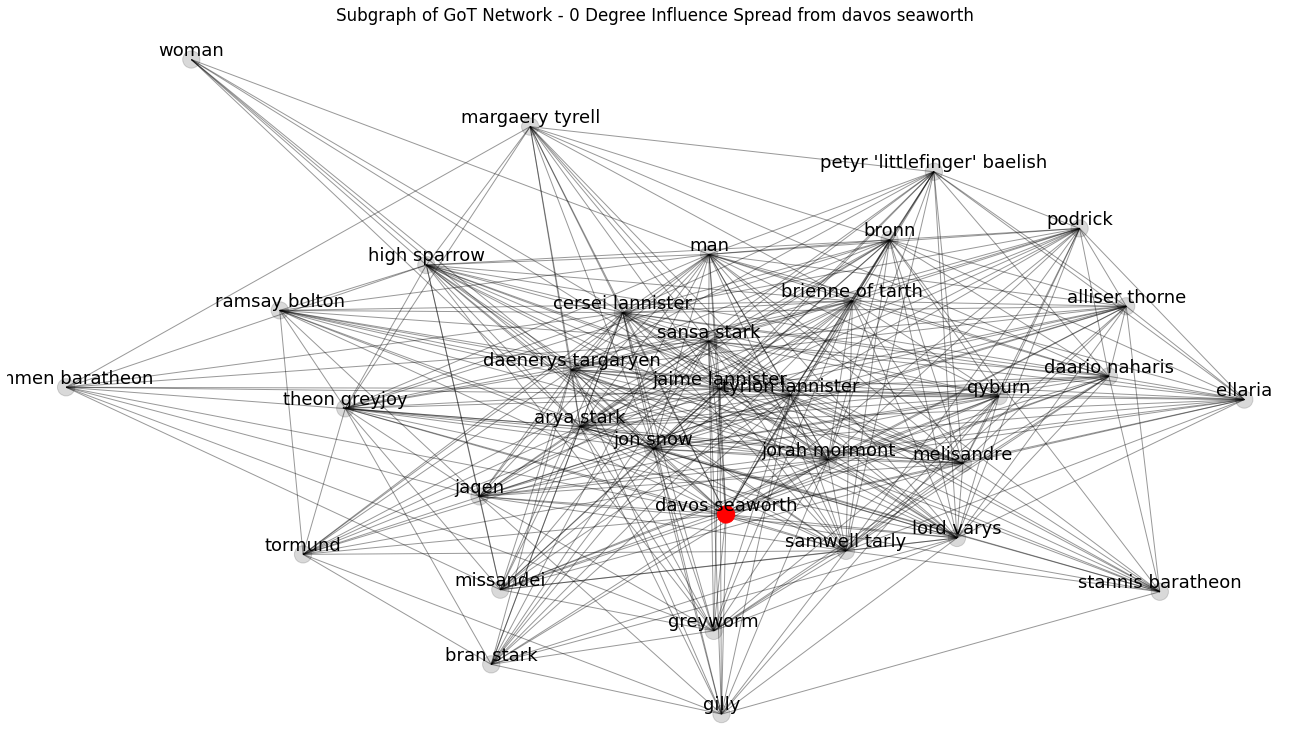

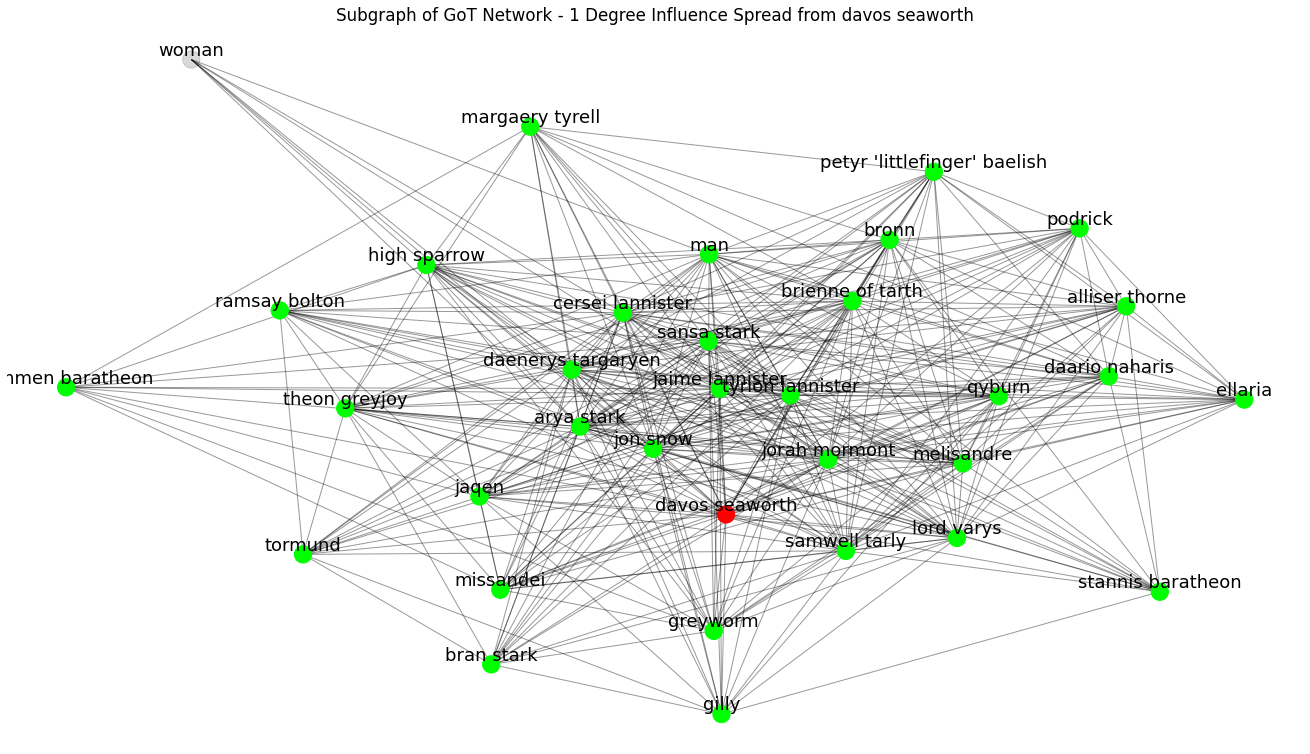

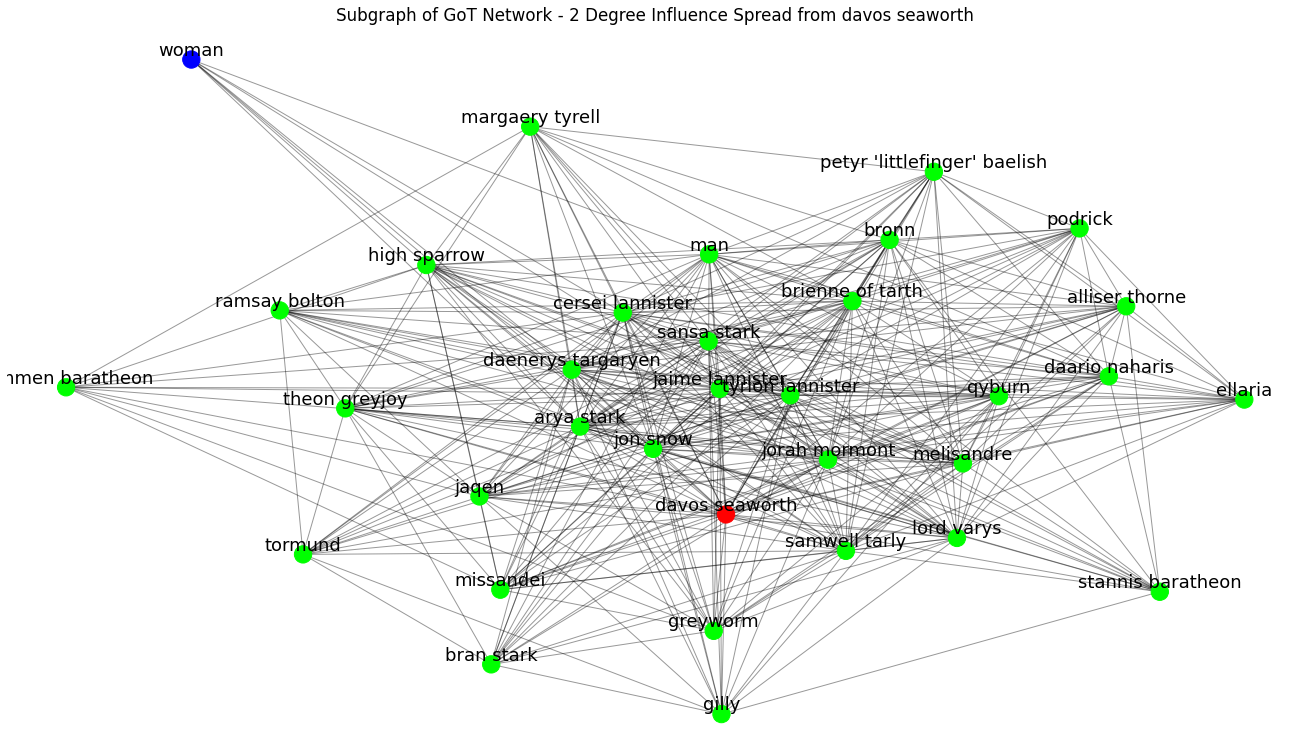

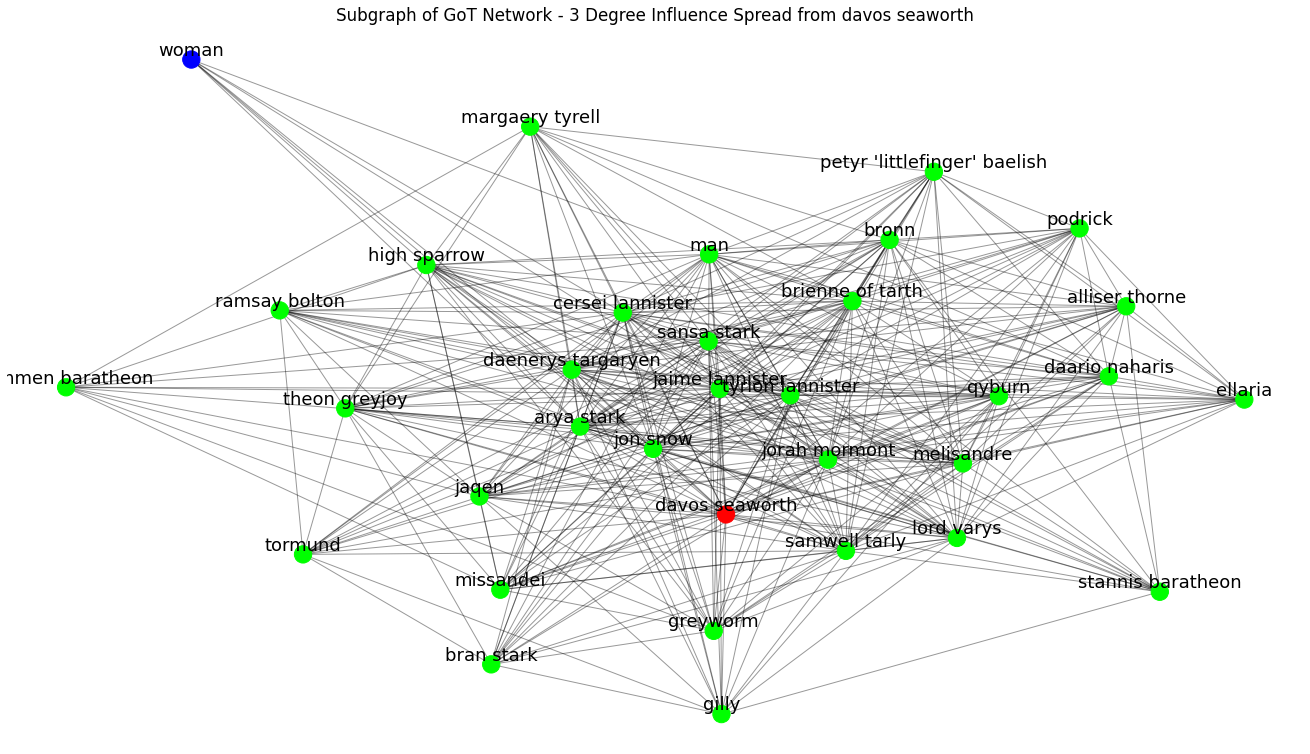

In [386]:
# make multiple plots and save each as a png file

# colors = [(255/255, 0, 0, sid) for sid in scaled_influence_decay] + [(0,0,0,.15)]
colors = [(1,0,0,1), (0,1,0,1), (0,0,1,1), (0,0.5,0.5,1), (0,0,0,.15)]

name = "davos seaworth"
for degree in range(4):
    color_map = assign_node_colors(g=G_subsub, name=name, degrees_to_color=degree, colors=colors)
    labels = nx.get_node_attributes(G_subsub, 'name')
    nx.draw(
        G_subsub, 
        node_color=color_map, 
        edge_color="#00000066", 
        pos=pos, 
        labels=labels,
        with_labels=True, 
        font_size=18, 
        verticalalignment="bottom"
    )
    plt.title(f"Subgraph of GoT Network - {degree} Degree Influence Spread from {name}")
    plt.savefig(f'{degree}.png', bbox_inches='tight')
    plt.show()

In [387]:
# convert the png files to a GIF to visualize the simulation
fp_in = "*.png"
fp_out = "influence_spread_simulation.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1600, loop=0)

### What if the graph is disconnected?

Our simulation works fine when the graph is fully connected, or when there are no isolated pockets of nodes.  But what if there are?  These isolated pockets, or subgraphs, are called connected components, and we can find all of them.  Instead of seeding 1 node, we will need to seed 1 node in every connected component/subgraph.  Each subgraph will have nodes of varying centrality.  We can choose to seed the ones with the highest centrality measure in each subgraph.  That will be the strategy for ensuring our directed influence campaign gets complete coverage.  In practice, it is sometimes impossible to cover every subgraph due to time constraints, so choosing the largest n subgraphs (or largest n connected components) could be suitable strategy.  

We can further extend our simulation using the ideas of minimum spanning trees and breadth and depth first searches.  If we assume that each node only sends the message to 1 person, it is still possible to achieve percolation through the network, assuming we also target every connected component.  
* A breadth first search would help us find a path order in which our seed could tell all their friends, and then they would tell their friends who have not already heard the message, etc.  
* A depth first search would help us find a path in which each node sends the message to one of their friends who has not already received the message.  

In [416]:
# invert the edge weights, as we will use a minimum spanning tree, 
# which finds minimum weights, but we want the tree of the strongest relationships so we need to invert them
edges_weighted_by_id_inv = 1 / np.array(list(edges_weighted_by_id.values()))

# create sparse adjacency matrix
nbr_nodes = len(nodes)
matrix_shape = (nbr_nodes, nbr_nodes)
rows, cols = zip(*list(edges_weighted_by_id))
sparse_mat = coo_matrix((edges_weighted_by_id_inv, (rows, cols)), shape=matrix_shape)

# find the graph's connected components
nbr_graph_components, graph_components = csgraph.connected_components(sparse_mat)

In [417]:
# reverse the node name to ID map so that it's easy to determine name when given a node ID
node_id_to_name_map = {v: k for k, v in node_to_id_map.items()}

In [418]:
# view the names of nodes who are in different components
largest_component, largest_component_nodes = 0, 0
for component in range(nbr_graph_components):
    nodes_in_component = [
        nname for nid, nname in node_id_to_name_map.items() 
        if nid in np.where(graph_components == component)[0].tolist()
    ]
    if len(nodes_in_component) > largest_component_nodes:
        largest_component = component
        largest_component_nodes = len(nodes_in_component)
    print(f"Nodes in component {component} of size {len(nodes_in_component)}:\n{nodes_in_component}\n")        

Nodes in component 0 of size 434:
['innkeeper', 'rorge', 'bobono', 'hot pie', 'olyvar', 'olly', 'dothraki matron', 'septa unella', 'morgan', 'prostitute', 'quorin', "sandor 'the hound' clegane", 'tanner', 'dim dalba', 'unsullied', 'protester', 'bystanders', 'gared', 'bowen marsh', 'aemon', 'gold cloak', 'glover', 'cassel', 'lollys stokeworth', 'joffrey dwarf', 'quick', 'dirah', 'young benjen', 'messenger', 'rickard', 'bianca', 'captain', 'portan', 'edmure', 'everybody', 'pyat pree', 'qyburn', 'mandon', 'irri', 'clarenzo', 'shadow tower brother', 'frey men', 'ersei', 'qhorin', 'stannis baratheon', 'donnel', 'blonde prostitute', 'meryn', 'barristan selmy', 'roz', 'militant', 'violet', 'walda', 'ranger', 'harry', 'dornish prince', 'dany', 'arthur', 'oberyn martell', 'karstark', 'lord bolton', 'salladhor', 'guard', 'teela', 'announcer', 'torturer', 'tywin lannister', 'jojen', 'buyer', 'attendant', 'daario naharis', 'loboda', 'balon dwarf', 'balon greyjoy', 'officer', 'mace tyrell', 'john r

In [419]:
# verify that the singleton nodes truly do not have any links
sparse_mat.tocsr()[np.where(graph_components != 0)[0].tolist(), :].sum(axis=1)

matrix([[0.],
        [0.],
        [0.]])

In [404]:
# slice the matrix
sparse_mat_sub = sparse_mat.tocsr()[nodes_in_components[largest_component], :]
sparse_mat_sub = sparse_mat_sub.tocsr()[:, nodes_in_components[largest_component]]

# the node with the highest centrality in the subgraph could be a starting point
# we could also use agreeableness or our composite score here
starting_node = list(centrality_betw)[0] # dict has already by sorted by descending centrality

bfo = csgraph.breadth_first_order(
    sparse_mat_sub, 
    i_start=starting_node, 
    directed=False, 
    return_predecessors=False
)
bfo = [node_id_to_name_map[i] for i in bfo]

dfo = csgraph.depth_first_order(
    sparse_mat_sub, 
    i_start=starting_node, 
    directed=False, 
    return_predecessors=False
)
dfo = [node_id_to_name_map[i] for i in dfo]

print("Breadth first:\n", bfo, "\n\nDepth first:\n", dfo)

Breadth first:
 ['daenerys targaryen', 'rorge', 'hot pie', 'olly', 'septa unella', 'prostitute', "sandor 'the hound' clegane", 'unsullied', 'gold cloak', 'glover', 'lollys stokeworth', 'quick', 'messenger', 'rickard', 'pyat pree', 'qyburn', 'irri', 'shadow tower brother', 'qhorin', 'stannis baratheon', 'meryn', 'oberyn martell', 'karstark', 'salladhor', 'guard', 'tywin lannister', 'daario naharis', 'loboda', 'mace tyrell', 'sparrow', 'owner', 'umber', 'gilly', 'waldery frey', 'shae', 'robin', 'pyatt pree', 'master', 'lyanna stark', 'survivor', 'mance', 'radzal mo eraz', 'lyanna mormont', 'marwyn', 'goatherd', 'ramsay bolton', 'kraznys', 'quaithe', 'eddard stark', 'edd', 'grenn', 'podrick', 'woman', 'rickard karstark', 'euron greyjoy', 'septa', 'hizdahr zo loraq', 'trystane', 'silk king', 'walder frey', 'samwell tarly', 'lysa', 'waymar royce', 'tormund', 'lord varys', 'leader', 'sansa stark', 'ygritte', 'myranda', 'randyll', 'roose bolton', 'izembaro', 'yohn royce', 'ros', 'white rat', 

By seeding the message to the nodes in each connected component with the highest centrality, we have a game plan for spreading the message through the network.  Here we have only explored seeding the largest connected component, but that is because it contains nearly every node and the other 3 components had 1 node each.  So we would simply send the message to the 3 individual nodes in those components.  But in larger networks, we could use centrality to determine the best seed node for every component, and we could rest assured that by seeding them, our message has the best chance of achieving total coverage and spreading in an efficient way.


# Extra credit: Network in Virtual Reality

We can export the edge data to a JSON file so that it can be read by the JavaScript A-Frame library and rendered in VR.

In [218]:
output_df.head()

source_name   target_name  source_id  target_id    weight
0          gared  waymar royce         17        145  3.391211
1          gared          will         17        290  2.802039
2   waymar royce          will        145        290  3.391211
3  septa mordane   sansa stark        147        155  1.259921
4       jon snow    robb stark        288        397  5.289572

In [237]:
# filter the data to the links maintained in the visualized graph
# nodes_kept_from_df = [int(n) for n in G_subsub.nodes()]
edges_kept_from_df = [(int(e[0]), int(e[1])) for e in G_subsub.edges()]
sources, targets = [e[0] for e in edges_kept_from_df], [e[1] for e in edges_kept_from_df]
df_sub = output_df[(
    (output_df['source_id'].isin(sources)) 
    & (output_df['target_id'].isin(targets))
)
].copy().reset_index(drop=True)

# scale the edge weights to values that are usable by a-frame
vr_scaler = MinMaxScaler(feature_range=(1, 5))
df_sub['weight'] = vr_scaler.fit_transform(df_sub['weight'].values.reshape(-1,1))
df_sub['weight'] = df_sub['weight'].apply(lambda x: np.round(x,0)).astype(int)
df_sub.head()

source_name      target_name  source_id  target_id  weight
0          jon snow    theon greyjoy        288        312       3
1        bran stark         jon snow        395        288       3
2        bran stark    theon greyjoy        395        312       2
3  cersei lannister  jaime lannister         90        412       5
4        arya stark      sansa stark        258        155       4

In [238]:
json_output = {
    "nodes": [{"id": n} for n in list(set(df_sub['source_name'].tolist() + df_sub['target_name'].tolist()))],
    "links": df_sub[['source_name', 'target_name', 'weight']].rename(
        columns={"source_name": "source", "target_name": "target", "weight": "value"}
    ).to_dict(orient="records"),
}
print(len(json_output['nodes']), len(json_output['links']))

34 534


In [239]:
with open("../virtual_reality_network/myGraphData.json", "w") as f:
    json.dump(json_output, f)

Now in a new terminal, cd into the /virtual_reality_network folder and run:

`python3 -m http.server 8001`

and open a web browswer to localhost:8001